In [4]:
import nltk
import numpy as np
from string import punctuation
nltk.download('conll2002')
from nltk.corpus import conll2002
train_esp_org = conll2002.iob_sents('esp.train') # Train, ned.train => Neerlandès
test_esp_a_org = conll2002.iob_sents('esp.testa') # Dev
test_esp_b_org = conll2002.iob_sents('esp.testb') # Test
import spacy
#!python -m spacy download es_core_web_sm
from spacy import displacy
from spacy.tokens import Doc, Span
from nltk.tokenize import sent_tokenize, word_tokenize
nlp = spacy.load('es_core_news_sm')
from nltk.stem import SnowballStemmer
nltk.download('averaged_perceptron_tagger')
stemmer_esp = SnowballStemmer('spanish')

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\gerar\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gerar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Creem codificacions IO i BIOW

In [5]:
# Per passar-ho a IO --> substituir B per I
train_esp_io = []
test_esp_a_io = []
test_esp_b_io = []

for text in [(train_esp_org,train_esp_io), (test_esp_a_org,test_esp_a_io), (test_esp_b_org,test_esp_b_io)]:
    for sentence in text[0]:
        sent = []
        for word in sentence:
            if word[2] in ['B-LOC','B-PER','B-ORG','B-MISC']:
                sent.append((word[0], word[1], 'I-' + word[2][2:]))
            else:
                sent.append(word)
        text[1].append(sent)

# Per passar-ho a BIOW --> sempre que vingui una B sense una I posterior, substituim aquesta B per W, que voldrà dir paraula aïllada 
train_esp_iobw = []
test_esp_a_iobw = []
test_esp_b_iobw = []

for text in [(train_esp_org,train_esp_iobw), (test_esp_a_org,test_esp_a_iobw), (test_esp_b_org,test_esp_b_iobw)]:
    for sentence in text[0]:
        sent = []
        for i in range(len(sentence)):
            if i < len(sentence)-1: 
                if sentence[i][2] in ['B-LOC','B-PER','B-ORG','B-MISC'] and sentence[i+1][2] not in ['I-LOC','I-PER','I-ORG','I-MISC']:
                    sent.append((sentence[i][0], sentence[i][1], 'W-' + sentence[i][2][2:]))    
                else: 
                    sent.append(sentence[i])
                    
            else: 
                if sentence[i][2] in ['B-LOC','B-PER','B-ORG','B-MISC']:
                    sent.append((sentence[i][0], sentence[i][1], 'W-' + sentence[i][2][2:])) 
                else: 
                    sent.append(sentence[i])
        text[1].append(sent)

print(train_esp_io[0:3])

[[('Melbourne', 'NP', 'I-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'I-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'I-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')], [('-', 'Fg', 'O')], [('El', 'DA', 'O'), ('Abogado', 'NC', 'I-PER'), ('General', 'AQ', 'I-PER'), ('del', 'SP', 'I-PER'), ('Estado', 'NC', 'I-PER'), (',', 'Fc', 'O'), ('Daryl', 'VMI', 'I-PER'), ('Williams', 'NC', 'I-PER'), (',', 'Fc', 'O'), ('subrayó', 'VMI', 'O'), ('hoy', 'RG', 'O'), ('la', 'DA', 'O'), ('necesidad', 'NC', 'O'), ('de', 'SP', 'O'), ('tomar', 'VMN', 'O'), ('medidas', 'NC', 'O'), ('para', 'SP', 'O'), ('proteger', 'VMN', 'O'), ('al', 'SP', 'O'), ('sistema', 'NC', 'O'), ('judicial', 'AQ', 'O'), ('australiano', 'AQ', 'O'), ('frente', 'RG', 'O'), ('a', 'SP', 'O'), ('una', 'DI', 'O'), ('página', 'NC', 'O'), ('de', 'SP', 'O'), ('internet', 'NC', 'O'), ('que', 'PR', 'O'), ('imposibilita', 'VMI', 'O'), ('el', 'DA', 'O'), ('cumplimiento', 'NC', 'O'),

### Feature functions 

#### Creem funcions per afegir lemmas a l'input del CRF

In [6]:
def add_lemmas(train, val, test):
    lemmas_train = process_sentences(train)
    lemmas_val = process_sentences(val)
    lemmas_test = process_sentences(test)
    return lemmas_train, lemmas_val, lemmas_test

def process_sentences(sentences):
    lemmas = []
    for sent in sentences:
        lemas_sent = []
        sentence = ' '.join([i for i, _, _ in sent])
        doc = nlp(sentence)
        for i in doc:
            lemma = i.lemma_
            lemas_sent.append(lemma)
        lemmas.append(lemas_sent)
    return lemmas
    

lemmas_train,lemmas_val,lemmas_test = add_lemmas(train_esp_iobw,test_esp_b_iobw,test_esp_a_iobw)

In [7]:
def ampliar_lemmas(particio,lemmas):
    new = []
    for i in range(len(particio)):
        sent = []
        for j in range(len(particio[i])):
            tuple = (particio[i][j][0],particio[i][j][1],lemmas[i][j],particio[i][j][2])
            sent.append(tuple)
        new.append(sent)
    return new

train_esp = ampliar_lemmas(train_esp_org, lemmas_train)
test_esp_b = ampliar_lemmas(test_esp_b_org, lemmas_val)
test_esp_a = ampliar_lemmas(test_esp_a_org, lemmas_test)

print(train_esp[0:3])
print(test_esp_b[0:3])
print(test_esp_a[0:3])


[[('Melbourne', 'NP', 'Melbourne', 'B-LOC'), ('(', 'Fpa', '(', 'O'), ('Australia', 'NP', 'Australia', 'B-LOC'), (')', 'Fpt', ')', 'O'), (',', 'Fc', ',', 'O'), ('25', 'Z', '25', 'O'), ('may', 'NC', 'may', 'O'), ('(', 'Fpa', '(', 'O'), ('EFE', 'NC', 'EFE', 'B-ORG'), (')', 'Fpt', ')', 'O'), ('.', 'Fp', '.', 'O')], [('-', 'Fg', '-', 'O')], [('El', 'DA', 'el', 'O'), ('Abogado', 'NC', 'Abogado', 'B-PER'), ('General', 'AQ', 'General', 'I-PER'), ('del', 'SP', 'del', 'I-PER'), ('Estado', 'NC', 'Estado', 'I-PER'), (',', 'Fc', ',', 'O'), ('Daryl', 'VMI', 'Daryl', 'B-PER'), ('Williams', 'NC', 'Williams', 'I-PER'), (',', 'Fc', ',', 'O'), ('subrayó', 'VMI', 'subrayar', 'O'), ('hoy', 'RG', 'hoy', 'O'), ('la', 'DA', 'el', 'O'), ('necesidad', 'NC', 'necesidad', 'O'), ('de', 'SP', 'de', 'O'), ('tomar', 'VMN', 'tomar', 'O'), ('medidas', 'NC', 'medida', 'O'), ('para', 'SP', 'para', 'O'), ('proteger', 'VMN', 'proteger', 'O'), ('al', 'SP', 'al', 'O'), ('sistema', 'NC', 'sistema', 'O'), ('judicial', 'AQ', 'j

#### Creem gazetteers

In [8]:
# Gazzeter creation from training data
gazzeter_loc = set()
gazzeter_org = set()
gazzeter_per = set()
gazzeter_misc = set()

for sentence in train_esp_org:
    for word, _ ,label in sentence:
        if label == 'B-LOC' or label == 'I-LOC':
            gazzeter_loc.add(word)
        elif label == 'B-ORG' or label == 'I-ORG':
            gazzeter_org.add(word)
        elif label == 'B-PER' or label == 'I-PER':
            gazzeter_per.add(word)
        elif label == 'B-MISC' or label == 'I-MISC':
            gazzeter_misc.add(word)



#### Creem funció word2features per trobar les features de les paraules

In [9]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    lemma = sent[i][2]

    features = {
        'word': word, 
        'word.isdigit()': word.isdigit(),
        'punctuation': any(p in word for p in punctuation),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'postag': postag,
        'lemma': lemma,
        #'root': stemmer_esp.stem(word),
        #'length': str(len(word)),
        'word[:1]': word[:1],
        'word[:2]': word[:2],
        'word[:3]': word[:3],
        #'is_location': word in gazzeter_loc,
        #'is_organization': word in gazzeter_org,
        #'is_person': word in gazzeter_per,
        #'is_miscellaneous': word in gazzeter_misc
    }
    # Afegim informació sobre les paraules anterior i posterior en la frase
    '''
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1, 
            '-1:word.isdigit()': word1.isdigit(),
            '-1:punctuation': any(p in word1 for p in punctuation),
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word[-1:]': word1[-1:],
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle()
        })
    else: # Si és inici de paraula posem (Beggining Of Sentence)
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '-1:word': word1, 
            '-1:word.isdigit()': word1.isdigit(),
            '-1:punctuation': any(p in word1 for p in punctuation),
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word[-1:]': word1[-1:],
            '-1:word.isupper()': word1.isupper(),
            '-1:word.istitle()': word1.istitle()
        })
    else: # Si és final de paraula posem (End Of Sentence)
        features['EOS'] = True
    '''
    return features
    
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, lemma, label in sent]

In [10]:
sent2features(train_esp[0][5:7])

[{'word': '25',
  'word.isdigit()': True,
  'punctuation': False,
  'word[-3:]': '25',
  'word[-2:]': '25',
  'word[-1:]': '5',
  'word.isupper()': False,
  'word.istitle()': False,
  'postag': 'Z',
  'lemma': '25',
  'word[:1]': '2',
  'word[:2]': '25',
  'word[:3]': '25'},
 {'word': 'may',
  'word.isdigit()': False,
  'punctuation': False,
  'word[-3:]': 'may',
  'word[-2:]': 'ay',
  'word[-1:]': 'y',
  'word.isupper()': False,
  'word.istitle()': False,
  'postag': 'NC',
  'lemma': 'may',
  'word[:1]': 'm',
  'word[:2]': 'ma',
  'word[:3]': 'may'}]

#### Preparem Training i datasets de test

In [11]:
train_esp_def = np.array([sent2features(s) for s in train_esp])
test_esp_a_def = np.array([sent2features(s) for s in test_esp_a])
test_esp_b_def = np.array([sent2features(s) for s in test_esp_b])

y_train_esp = np.array([sent2labels(s) for s in train_esp])
y_test_esp_a = np.array([sent2labels(s) for s in test_esp_a])
y_test_esp_b = np.array([sent2labels(s) for s in test_esp_b])

train_esp_def.shape, y_train_esp.shape



C:\Users\gerar\AppData\Local\Temp\ipykernel_27348\96327820.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_esp_def = np.array([sent2features(s) for s in train_esp])
C:\Users\gerar\AppData\Local\Temp\ipykernel_27348\96327820.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_esp_a_def = np.array([sent2features(s) for s in test_esp_a])
C:\Users\gerar\AppData\Local\Temp\ipykernel_27348\96327820.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with d

((8323,), (8323,))

#### Construim CRF amb Sklearn-crfsuite

In [12]:
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(algorithm='lbfgs',
                           c1=0.1,
                           c2=0.1,
                           max_iterations=100,
                           all_possible_transitions=True,
                           verbose=True)

try:
    crf.fit(train_esp_def, y_train_esp)
except AttributeError:
    pass


loading training data to CRFsuite: 100%|██████████| 8323/8323 [00:01<00:00, 4492.87it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 76948
Seconds required: 0.475

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.37  loss=343970.65 active=76645 feature_norm=1.00
Iter 2   time=0.41  loss=330897.86 active=75956 feature_norm=6.54
Iter 3   time=0.24  loss=258714.72 active=73193 feature_norm=5.60
Iter 4   time=1.50  loss=151293.62 active=73475 feature_norm=3.58
Iter 5   time=0.42  loss=106168.14 active=74536 feature_norm=4.23
Iter 6   time=0.22  loss=97898.81 active=76227 feature_norm=4.31
Iter 7   time=0.23  loss=91213.27 active=76010 feature_norm=4.71
Iter 8   time=0.22  loss=84239.92 active=76090 feature_norm=5.44
Iter 9   time=0.22  loss=63706.08 active=65355 feature_norm=8.74
Iter 10  

#### Definim funció que evaluarà el model amb codificació i sense

In [13]:
from sklearn.metrics import classification_report, f1_score

def evaluate_model(y_test,X_test):
    labels = list(crf.classes_)
    print(labels)

    y_pred = crf.predict(X_test)
    sorted_labels = sorted(labels)

    y_pred_list = [item for sublist in y_pred for item in sublist]
    y_true_list = [item for sublist in y_test for item in sublist]

    print(y_pred_list[0:30])
    print(y_true_list[0:30])

    report = classification_report(y_true_list, y_pred_list, labels = sorted_labels)
    print(report)
    print('F1 score macro avg:', f1_score(y_true_list, y_pred_list, average = 'macro'))

In [14]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model_clases(y_test,X_test):
    labels = ['LOC','PER','ORG','MISC','O']   
    print(labels)

    y_pred = crf.predict(X_test)
    sorted_labels = sorted(labels)

    y_pred_list = [item for sublist in y_pred for item in sublist]
    y_true_list = [item for sublist in y_test for item in sublist]

    # Descodifiquem per tal de tenir tot agrupat en les classes necessàries
    for i in range(len(y_pred_list)):
        if y_pred_list[i][0] in ['W','B','I']:
            y_pred_list[i] = y_pred_list[i][2:]
            
        if y_true_list[i][0] in ['W','B','I']:
            y_true_list[i] = y_true_list[i][2:]
            
            

    print(y_pred_list[0:30])
    print(y_true_list[0:30])

    report = classification_report(y_true_list, y_pred_list, labels = sorted_labels)
    print(report)
    print('F1 score macro avg:', f1_score(y_true_list, y_pred_list, average = 'macro'))
    cm = confusion_matrix(y_true_list, y_pred_list, labels = sorted_labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(sorted_labels); ax.yaxis.set_ticklabels(sorted_labels)

#### Evaluació del model amb val 

In [15]:
evaluate_model(y_test_esp_b,test_esp_b_def)

['B-LOC', 'O', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O']
              precision    recall  f1-score   support

       B-LOC       0.76      0.76      0.76      1084
      B-MISC       0.71      0.53      0.61       339
       B-ORG       0.83      0.84      0.83      1400
       B-PER       0.82      0.84      0.83       735
       I-LOC       0.63      0.62      0.63       325
      I-MISC       0.60      0.54      0.57       557
       I-ORG       0.82      0.79      0.81      1104
       I-PER       0.88      0.92      0.90       634
           O       0.99      1.00      0.99     45355

    accuracy                      

['LOC', 'PER', 'ORG', 'MISC', 'O']
['LOC', 'LOC', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['LOC', 'LOC', 'O', 'LOC', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
              precision    recall  f1-score   support

         LOC       0.65      0.80      0.72      1321
        MISC       0.52      0.54      0.53      1099
           O       0.99      0.99      0.99     45356
         ORG       0.82      0.73      0.77      3066
         PER       0.84      0.83      0.84      2081

    accuracy                           0.96     52923
   macro avg       0.76      0.78      0.77     52923
weighted avg       0.96      0.96      0.96     52923

F1 score macro avg: 0.7686763504778588


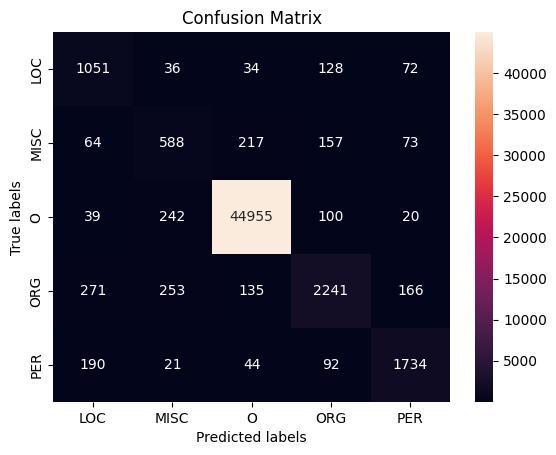

In [16]:
evaluate_model_clases(y_test_esp_a,test_esp_a_def)

['LOC', 'PER', 'ORG', 'MISC', 'O']
['LOC', 'LOC', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O']
['LOC', 'LOC', 'O', 'O', 'O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'MISC', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O']
              precision    recall  f1-score   support

         LOC       0.75      0.75      0.75      1409
        MISC       0.66      0.56      0.61       896
           O       0.99      1.00      0.99     45355
         ORG       0.83      0.83      0.83      2504
         PER       0.85      0.88      0.87      1369

    accuracy                           0.97     51533
   macro avg       0.82      0.80      0.81     51533
weighted avg       0.97      0.97      0.97     51533

F1 score macro avg: 0.8091648377907248


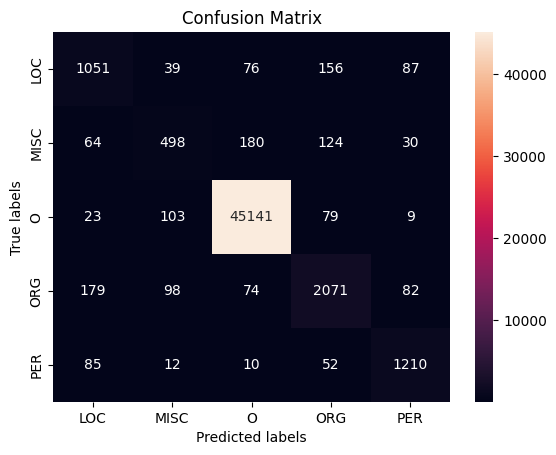

In [17]:
evaluate_model_clases(y_test_esp_b,test_esp_b_def)

#### Etiquetem textos reals

##### Definim funcions que permeten la visualització de l'etiquetatge

In [21]:
# Definim funcions que permeten la visualització de l'etiquetatge

def visualize_text_with_labels(predicted_labels): # Function to visualize the text
    nlp = spacy.blank("es")  
    words = [token for sentence in predicted_labels for token, _ in sentence]
    spaces = [True] * len(words)  # Assume all tokens are followed by spaces
    doc = Doc(nlp.vocab, words=words, spaces=spaces)
    ents = []

    char_position = 0
    for sentence in predicted_labels:
        for word, label in sentence:
            if label != 'O':
                span_start = char_position
                span_end = char_position + len(word)
                token_start = None
                token_end = None

                # Find the token indices that correspond to the character positions
                for token in doc:
                    if token.idx == span_start:
                        token_start = token.i
                    if token.idx + len(token.text) == span_end:
                        token_end = token.i

                if token_start is not None and token_end is not None:
                    ents.append(Span(doc, start=token_start, end=token_end+1, label=label))

            # Increment char_position by the length of the word plus 1 for whitespace
            char_position += len(word) + 1

    doc.ents = ents

    colors = {"B-LOC": "#FFB6C1","I-LOC": "#FFB6C1", "B-PER": "#98FF98", "I-PER": "#98FF98", "B-ORG": "#C8A2C8", "I-ORG": "#C8A2C8", "B-MISC":"#FFFFE0","I-MISC":"#FFFFE0"}  # Define colors for each label
    options = {"ents": list(colors.keys()), "colors": colors}  # Use colors for specified labels
    displacy.render(doc, style="ent", options=options, jupyter=True)

def predict_raw_text(text):
    text_input = []
    nlp = spacy.load("es_core_news_sm")
    text_tok_sent = sent_tokenize(text)
    for sent in text_tok_sent:
        doc = nlp(sent)
        sentence = []
        words = word_tokenize(sent)
        for w in range(len(words)):
            sentence.append((words[w],'-', doc[w].lemma_))
        text_input.append(sentence)
    text_input_final = np.array([sent2features(s) for s in text_input],dtype=object)
    prediction = crf.predict(text_input_final)
    output = []
    for i in range(len(text_input)):
        sentence = []
        for j in range(len(text_input[i])):
            tuple = (text_input[i][j][0], prediction[i][j])
            sentence.append(tuple)
        output.append(sentence)
    visualize_text_with_labels( output)



In [22]:
text = """El famoso escritor peruano Mario Vargas Llosa asistió a la conferencia sobre literatura latinoamericana en
la ciudad de Buenos Aires. Durante su discurso, destacó la importancia de la narrativa en la sociedad actual.
Vargas Llosa es reconocido a nivel mundial por sus novelas, como 'La ciudad y los perros' y 
'Conversación en la catedral'. También ha sido galardonado con el Premio Nobel de Literatura en 2010. El evento fue organizado por la Universoidad de 
Buenos Aires y contó con la participación de diversos intelectuales y académicos. Entre los asistentes destacados se 
encontraban representantes de la editorial Alfaguara y la Fundación para las Letras Mexicanas. """
predict_raw_text(text)
